In [1]:

from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import os, sys
import pickle as pkl
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
from LRBv21 import LRBv21
from AnalyticCoolingCurves import *
from unpackConfigurationsMK import *
from refineGrid import refineGrid
from Morph import Profile, Morph

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *
import general.plotstyle


%matplotlib inline
# set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2


# Read balance file

In [2]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()


eqb["SPR45"]= dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = 2000)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
# file_write(eqb, "equilibrium_100k.pkl")

# Make BxBt and Lc scans

Text(0.5, 1.0, 'Flux expansion profiles')

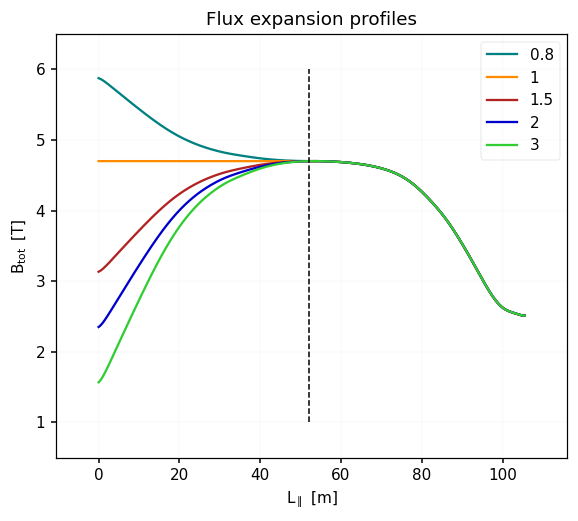

In [3]:
p = eqb["SPR45"]["ol"]

newp = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

list_bxbt = [0.8, 1, 1.5, 2, 3]
profiles_bxbt = {}

fig, ax = plt.subplots()

for bxbt in list_bxbt:
    profiles_bxbt[bxbt] = copy.deepcopy(newp)
    profiles_bxbt[bxbt].scale_BxBt(BxBt = bxbt)
    
    ax.plot(profiles_bxbt[bxbt]["S"], profiles_bxbt[bxbt]["Btot"], label = bxbt)
    
ax.vlines(newp["S"][newp["Xpoint"]], 1, 6, color = "k", lw = 1.0, linestyle = "--")
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## BxBt, no upstream

Text(0.5, 1.0, 'Flux expansion profiles')

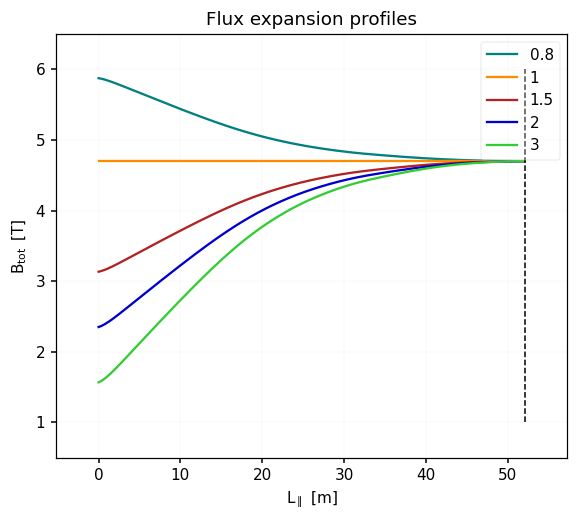

In [10]:
p = eqb["SPR45"]["ol"]

newp = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

list_bxbt = [0.8, 1, 1.5, 2, 3]
profiles_bxbt_belowx = {}

fig, ax = plt.subplots()

for bxbt in list_bxbt:
    profiles_bxbt_belowx[bxbt] = copy.deepcopy(newp)
    profiles_bxbt_belowx[bxbt].scale_BxBt(BxBt = bxbt)
    
    p = profiles_bxbt_belowx[bxbt]
    Xpoint = p["Xpoint"]
    for param in ["R", "Z", "Btot", "Bpol", "S", "Spol"]:
        profiles_bxbt_belowx[bxbt][param] = profiles_bxbt_belowx[bxbt][param][:Xpoint+1]
    
    
    ax.plot(profiles_bxbt_belowx[bxbt]["S"], profiles_bxbt_belowx[bxbt]["Btot"], label = bxbt)
    
ax.vlines(newp["S"][newp["Xpoint"]], 1, 6, color = "k", lw = 1.0, linestyle = "--")
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

## Lc

Text(0.5, 1.0, 'Connection length profiles')

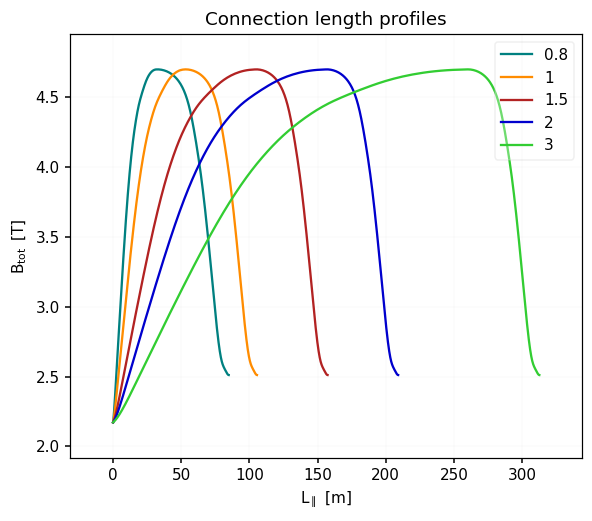

In [5]:
p = eqb["SPR45"]["ol"]

newp = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

list_Lc = [0.8, 1, 1.5, 2, 3]
profiles_Lc = {}

fig, ax = plt.subplots()

for Lc in list_Lc:
    profiles_Lc[Lc] = copy.deepcopy(newp)
    profiles_Lc[Lc].scale_Lc(scale_factor = Lc)
    
    p = profiles_Lc[Lc]
    ax.plot(profiles_Lc[Lc]["S"], profiles_Lc[Lc]["Btot"], label = Lc)
    # ax.plot(p["S"][p["Xpoint"]], p["Btot"][p["Xpoint"]], marker = "x", ms = 5, c = "k")
    
# ax.vlines(newp["S"][newp["Xpoint"]], 1, 6, color = "k", lw = 1.0, linestyle = "--")
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Connection length profiles")

# Set up thin radiation curve

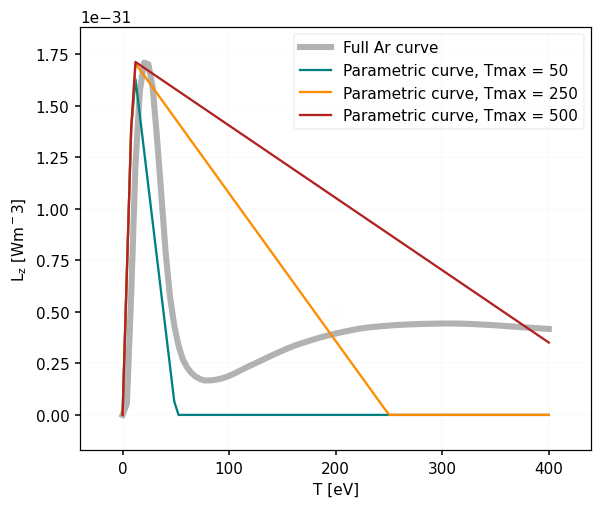

In [5]:
T = np.linspace(0,400,100)

def LfuncArParametricTri(T, Tmax = 60):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    max_pos = 10
    
    x0 = 0
    y0 = 0
    x1 = max_pos
    y1 = max
    x2 = Tmax
    y2 = 0
    
    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = 0

    
    return Lz

fig, ax = plt.subplots()

ax.plot(T, [LfuncKallenbach("Ar")(x) for x in T], lw = 4, alpha = 0.3, c = "k", label = r"Full Ar curve")
ax.plot(T, [LfuncArParametricTri(x, 50) for x in T], lw = 1.5, label = "Parametric curve, Tmax = 50")
ax.plot(T, [LfuncArParametricTri(x, 250) for x in T], lw = 1.5, label = "Parametric curve, Tmax = 250")
ax.plot(T, [LfuncArParametricTri(x, 500) for x in T], lw = 1.5, label = "Parametric curve, Tmax = 500")
ax.set_xlabel("T [eV]")
ax.set_ylabel("$L_z$ [$W m^-3$]")
ax.legend()
# ax.set_xlim(10,60)

# Setup and run DLS

In [6]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 1, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbach("Ar"), # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

# Run

## Bx/Bt

In [47]:
cvar = "density"
design = "SPR45"
side = "ol"

store_bxbt = dict()

# for bxbt in [3]:
for bxbt in list_bxbt:
    print(bxbt)
    d = eqb["SPR45"][side].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 12) # Don't solve up to xpoint cause it won't like it with narrow curves
    # SparRange = SparRange[-5:]
    # SparRange = [d["S"][d["Xpoint"]]]
    ## Unmitigated SPR45 peak power loads + 0.
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
        
    d = profiles_bxbt[bxbt].copy()
        
    try:
        results = LRBv21(constants, radios, d, 
                        SparRange, verbosity = 0, control_variable = cvar, 
                        Ctol = 1e-3, Ttol=1e-3,
                        dynamicGrid = True,
                        dynamicGridRefinementRatio = 30,
                        zero_qpllt = True)
    except KeyboardInterrupt:
        print("Stopped")

    store_bxbt[bxbt] = copy.deepcopy(results)
    

0.8
Solving...0.00...4.74...9.47...14.21...18.94...23.68...28.42...33.15...37.89...42.63...47.36...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


52.10...Complete in 25.9 seconds
1
Solving...0.00...4.74...9.47...14.21...18.94...23.68...28.42...33.15...37.89...42.63...47.36...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


52.10...Complete in 33.8 seconds
1.5
Solving...0.00...4.74...9.47...14.21...18.94...23.68...28.42...33.15...37.89...42.63...47.36...52.10...Complete in 40.8 seconds
2
Solving...0.00...4.74...9.47...14.21...18.94...23.68...28.42...33.15...37.89...42.63...47.36...52.10...Complete in 32.9 seconds
3
Solving...0.00...4.74...9.47...14.21...18.94...23.68...28.42...33.15...37.89...42.63...47.36...52.10...Complete in 30.8 seconds


## Bx/Bt, no upstream

In [43]:
cvar = "density"
design = "SPR45"
side = "ol"

store_bxbt_belowx = dict()

# for bxbt in [3]:
for bxbt in list_bxbt:
    print(bxbt)
    d = profiles_bxbt_belowx[bxbt].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    radios["upstreamGrid"] = False
    # SparRange = np.linspace(0, d["S"][d["Xpoint"]], 12) # Don't solve up to xpoint cause it won't like it with narrow curves
    SparRange = [0,20, 40, d["S"][d["Xpoint"]-10]]
    # SparRange = [d["S"][d["Xpoint"]]]
    ## Unmitigated SPR45 peak power loads + 0.
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
        
    
        
    try:
        results = LRBv21(constants, radios, d, 
                        SparRange, verbosity = 0, control_variable = cvar, 
                        Ctol = 1e-3, Ttol=1e-3,
                        dynamicGrid = True,
                        dynamicGridRefinementRatio = 30,
                        zero_qpllt = True)
    except KeyboardInterrupt:
        print("Stopped")

    store_bxbt_belowx[bxbt] = copy.deepcopy(results)
    

0.8
Solving...0.00...20.00...40.00...43.38...Complete in 6.1 seconds
1
Solving...0.00...20.00...40.00...43.38...Complete in 7.1 seconds
1.5
Solving...0.00...20.00...40.00...43.38...Complete in 7.4 seconds
2
Solving...0.00...20.00...40.00...43.38...Complete in 6.6 seconds
3
Solving...0.00...20.00...40.00...43.38...Complete in 9.0 seconds


## Lc

In [49]:
cvar = "density"
design = "SPR45"
side = "ol"

store_Lc = dict()

# for Lc in [3]: 
# for Lc in [list_Lc[0]]:
for Lc in list_Lc:
    print(Lc)
    d = profiles_Lc[Lc].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 10) # Don't solve up to xpoint cause it won't like it with narrow curves
    # SparRange = SparRange[-5:]
    # SparRange = [d["S"][d["Xpoint"]]]
    ## Unmitigated SPR45 peak power loads + 0.
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
        
    
        
    try:
        results = LRBv21(constants, radios, d, 
                        SparRange, verbosity = 0, control_variable = cvar, 
                        Ctol = 1e-4, Ttol=1e-2,
                        dynamicGrid = True,
                        dynamicGridRefinementRatio = 20,
                        zero_qpllt = True)
    except KeyboardInterrupt:
        print("Stopped")

    store_Lc[Lc] = copy.deepcopy(results)
    

0.8
Solving...0.00...3.49...6.98...10.46...13.95...17.44...20.93...24.41...27.90...31.39...Complete in 27.0 seconds
1
Solving...0.00...5.79...11.58...17.37...23.15...28.94...34.73...40.52...46.31...52.10...Complete in 38.3 seconds
1.5
Solving...0.00...11.54...23.08...34.62...46.16...57.70...69.24...80.78...92.33...103.87...Complete in 36.3 seconds
2
Solving...0.00...17.29...34.59...51.88...69.17...86.46...103.76...121.05...138.34...155.63...Complete in 34.8 seconds
3
Solving...0.00...28.80...57.59...86.39...115.19...143.98...172.78...201.58...230.37...259.17...Complete in 38.9 seconds


## Lc, thin curve

In [166]:
cvar = "density"
design = "SPR45"
side = "ol"

store_Lc_thin = dict()

# for Lc in [3]: 
for Lc in list_Lc:
    print(Lc)
    d = profiles_Lc[Lc].copy()
    constants = constants_default.copy() # Set settings to default
    
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 10) # Don't solve up to xpoint cause it won't like it with narrow curves
    # SparRange = [13.95]
    # SparRange = SparRange[-5:]
    # SparRange = [d["S"][d["Xpoint"]]]
    ## Unmitigated SPR45 peak power loads + 0.
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
        
    constants["Lfunc"] = lambda x: LfuncArParametricTri(x, 60)
        
    results = LRBv21(constants, radios, d, 
                    SparRange, verbosity = 0, control_variable = cvar, 
                    Ctol = 1e-3, Ttol=1e-2,
                    dynamicGrid = True,
                    dynamicGridRefinementRatio = 20,
                    zero_qpllt = True)


    store_Lc_thin[Lc] = copy.deepcopy(results)
    

0.8
Solving...0.00...3.49...6.98...10.46...13.95...17.44...20.93...24.41...27.90...31.39...Complete in 7.1 seconds
1
Solving...0.00...5.79...11.58...17.37...23.15...28.94...34.73...40.52...46.31...52.10...Complete in 7.6 seconds
1.5
Solving...0.00...11.54...23.08...34.62...46.16...57.70...69.24...80.78...92.33...103.87...Complete in 7.9 seconds
2
Solving...0.00...17.29...34.59...51.88...69.17...86.46...103.76...121.05...138.34...155.63...Complete in 7.7 seconds
3
Solving...0.00...28.80...57.59...86.39...115.19...143.98...172.78...201.58...230.37...259.17...Complete in 7.3 seconds


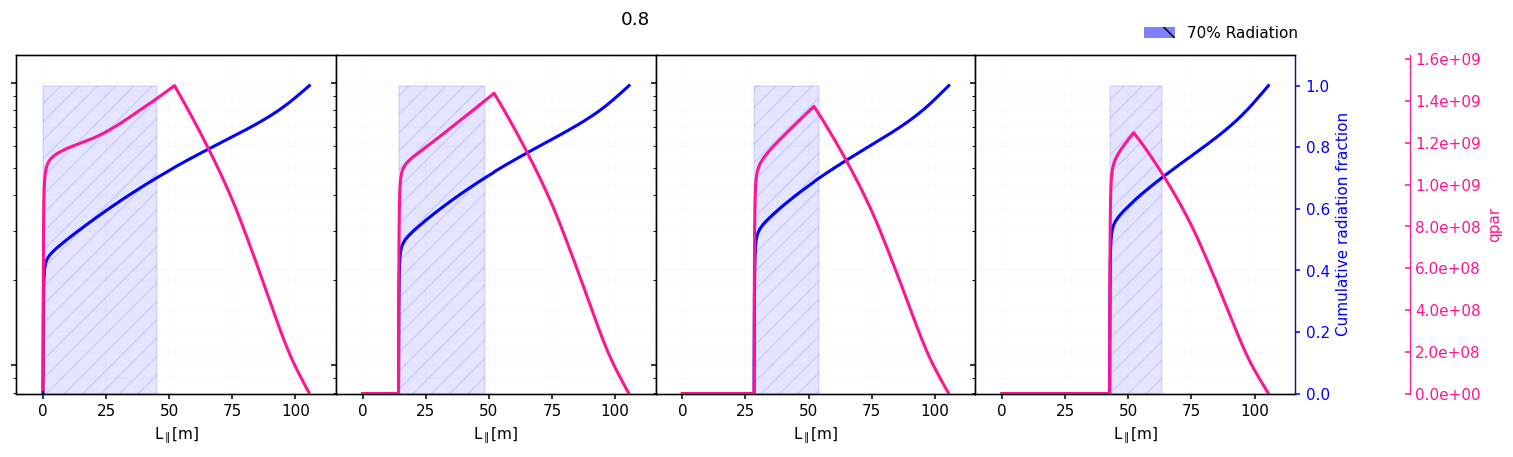

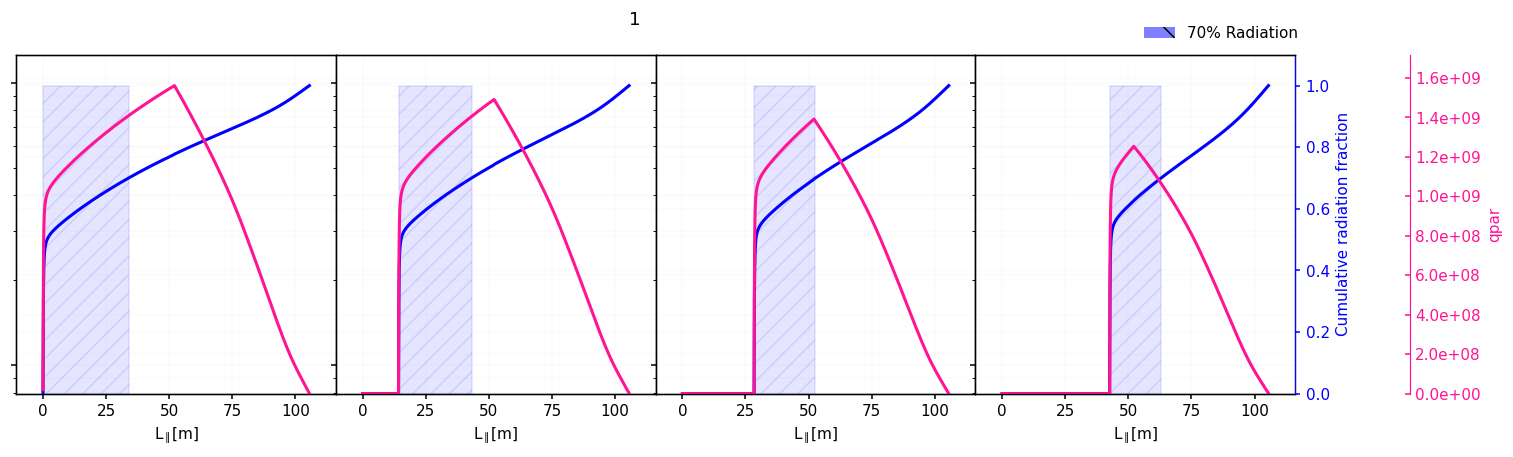

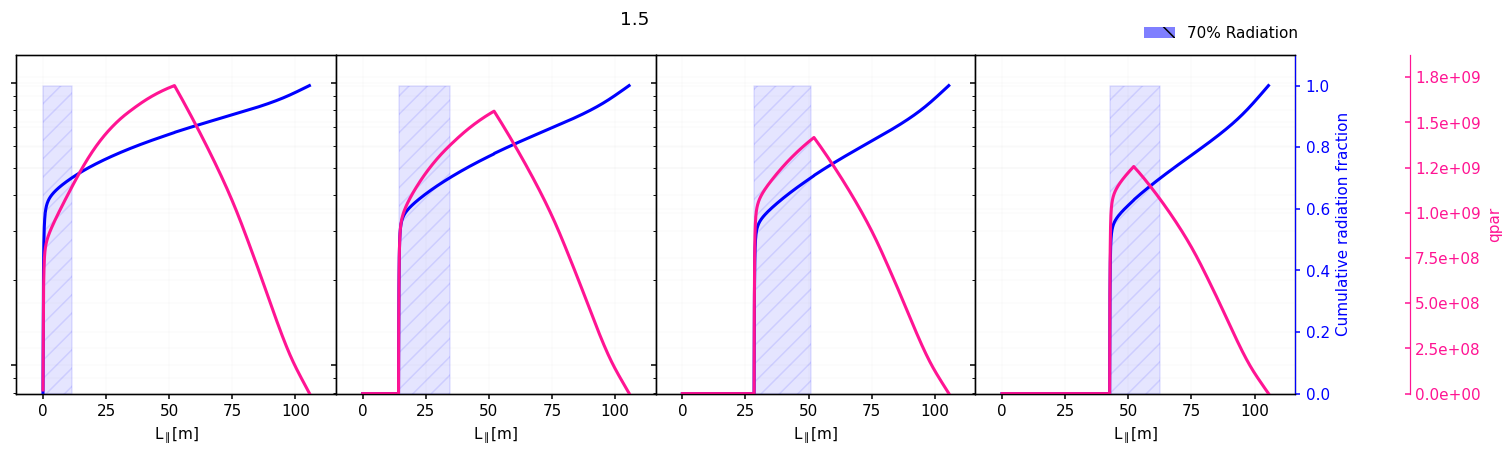

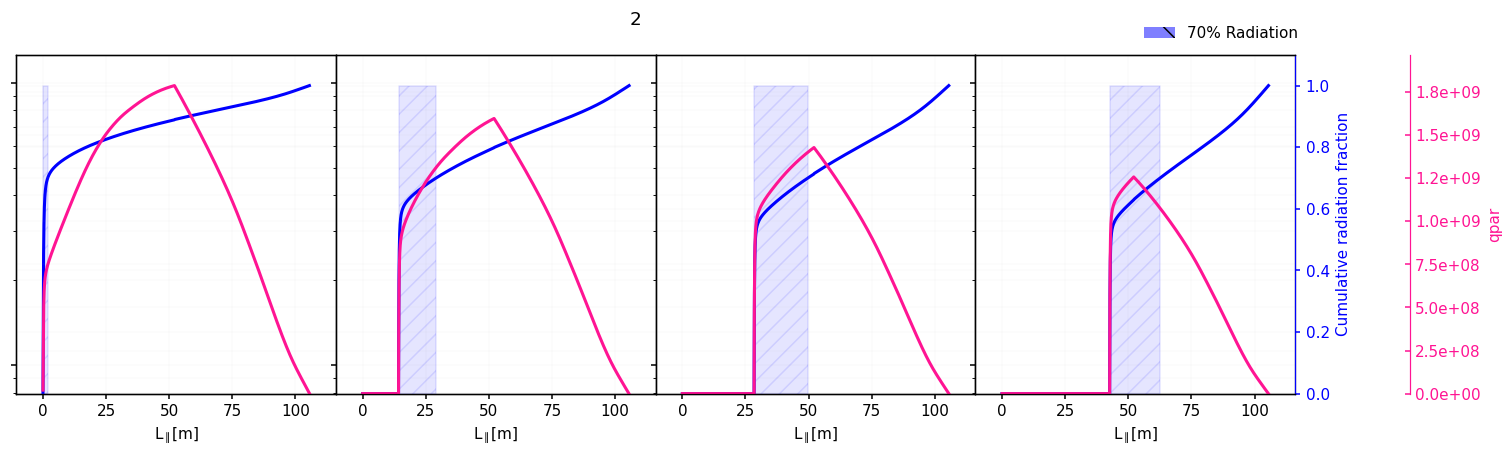

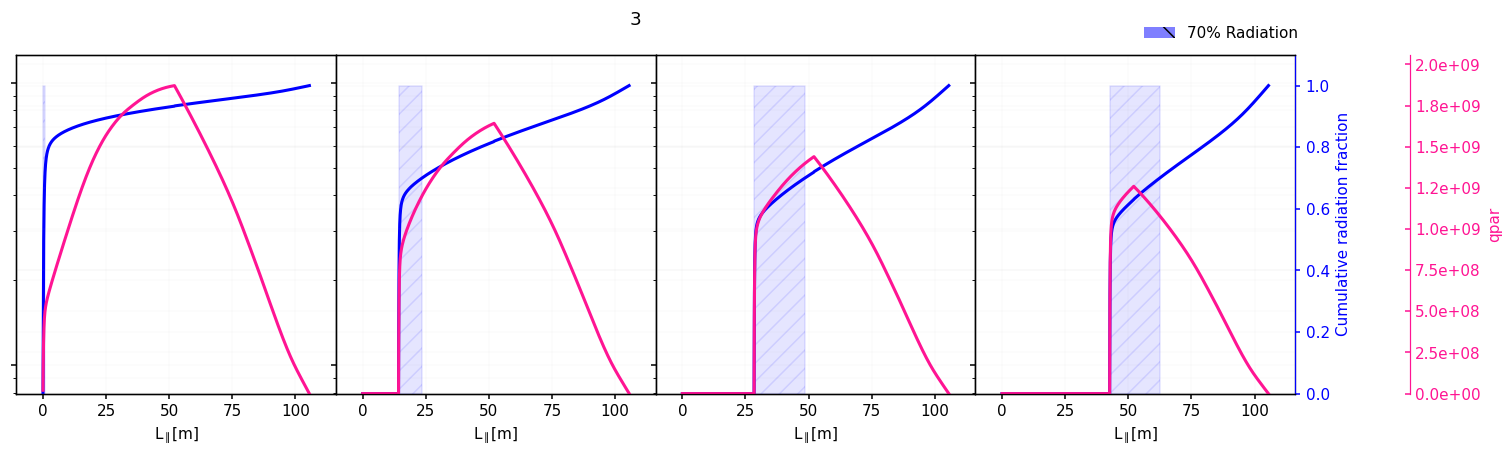

In [9]:
stores = store_bxbt_belowx
profiles = profiles_bxbt_belowx
for key in stores:
    p = profiles[key]
    s = stores[key]
    plot_profile_histories(p, s, [0,3,6,9], rad_threshold = 0.7, mode = "qpar", title = f"{key}")

## Lc, thin curve, zero target heat flux

In [119]:
cvar = "density"
design = "SPR45"
side = "ol"

store_Lc_thin_loqt = dict()

# for Lc in [3]: 
for Lc in list_Lc:
    print(Lc)
    d = profiles_Lc[Lc].copy()
    constants = constants_default.copy() # Set settings to default
    
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 10) # Don't solve up to xpoint cause it won't like it with narrow curves
    # SparRange = SparRange[-5:]
    # SparRange = [d["S"][d["Xpoint"]]]
    ## Unmitigated SPR45 peak power loads + 0.
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
        
    constants["Lfunc"] = lambda x: LfuncArParametricTri(x, 60)
        
    try:
        results = LRBv21(constants, radios, d, 
                        SparRange, verbosity = 0, control_variable = cvar, 
                        Ctol = 1e-3, Ttol=1e-3,
                        dynamicGrid = True,
                        dynamicGridRefinementRatio = 20,
                        zero_qpllt = True)
    except:
        print(f"Failed for Lc = {Lc}")
        print("Retrying!")
        results = LRBv21(constants, radios, d, 
                        SparRange, verbosity = 0, control_variable = cvar, 
                        Ctol = 1e-3, Ttol=1e-3,
                        dynamicGrid = True,
                        dynamicGridRefinementRatio = 20,
                        zero_qpllt = True)

    store_Lc_thin_loqt[Lc] = copy.deepcopy(results)
    

0.8
Solving...0.00...3.49...6.98...10.46...13.95...17.44...20.93...24.41...27.90...31.39...Complete in 20.0 seconds
1
Solving...0.00...5.79...11.58...17.37...23.15...28.94...34.73...40.52...46.31...52.10...Complete in 21.3 seconds
1.5
Solving...0.00...11.54...23.08...34.62...46.16...57.70...69.24...80.78...92.33...103.87...Complete in 19.9 seconds
2
Solving...0.00...17.29...34.59...51.88...69.17...86.46...103.76...121.05...138.34...155.63...Complete in 19.5 seconds
3
Solving...0.00...28.80...57.59...86.39...115.19...143.98...172.78...201.58...230.37...259.17...Complete in 18.3 seconds


# Scaling analysis

## BxBt

In [19]:
idx = 0
store = store_bxbt[2]
kappa0 = 2500

x = store["Sprofiles"][idx]
T = pad_profile(x, store["Tprofiles"][idx])
Tgrid = np.linspace(T.min(), T.max(), 1000)

Lz = [LfuncKallenbachAr(x) for x in Tgrid]

C0 = 7**(-2/7) * (2*kappa0)**(-3/14) * (sp.integrate.trapezoid(y = Tgrid**0.5 * Lz, x = Tgrid))**0.5

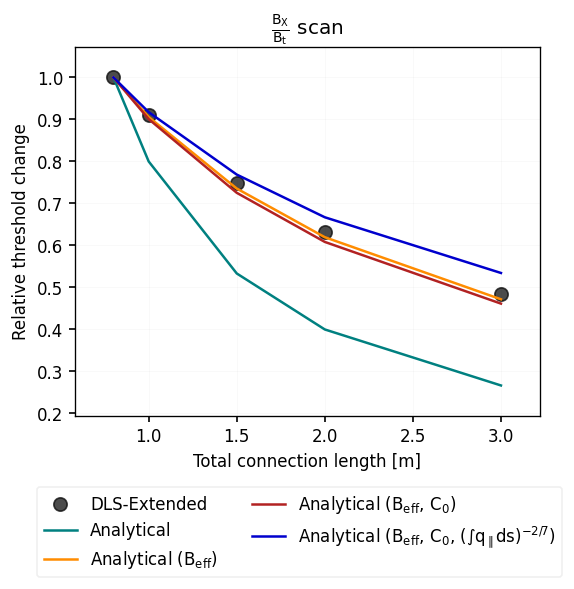

In [50]:
df = get_detachment_scalings(profiles_bxbt, store_bxbt)
x = df["BxBt"]


threshcalc = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
threshcalc2 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
threshcalc3 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7) * (df["C0"]/df["C0"][0])**(-1)
threshcalc4 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["qpar_integral"]/df["qpar_integral"][0])**(-2/7) * (df["C0"]/df["C0"][0])**(-1)
# threshcalc6 = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["qpar_integral"]/df["qpar_integral"][0])**(-2/7) * (df["C0"]/df["C0"][0])**(-1)
# threshcalc5 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["Tu"]/df["Tu"][0])**(-1) * (df["C0"]/df["C0"][0])**(-1)


fig, axes = plt.subplots(dpi = 120, figsize = (5,4))
ms = 0
axes.set_title(r"$\frac{B_{X}}{B_{t}}$ scan")
axes.plot(x, df["thresholds"]/df["thresholds"][0], marker = "o", lw = 0, ms = 8, c = "k", alpha = 0.7, label = "DLS-Extended")
axes.plot(x, threshcalc, marker = "x", label = "Analytical", ms = ms, lw = 1.5)
axes.plot(x, threshcalc2, marker = "*", label = "Analytical ($B_{eff}$)", ms = ms, lw = 1.5)
axes.plot(x, threshcalc3, marker = "v", label = "Analytical ($B_{eff}$, $C_{0}$)", ms = ms, lw = 1.5)
# axes.plot(x, threshcalc6, marker = "d", label = "Analytical ($B_{tot}$, $C_{0}$, $(\int q_{\parallel} ds)^{-2/7}$)", ms = ms, lw = 1.5)
axes.plot(x, threshcalc4, marker = "d", label = "Analytical ($B_{eff}$, $C_{0}$, $(\int q_{\parallel} ds)^{-2/7}$)", ms = ms, lw = 1.5)
# axes.plot(x, threshcalc5, marker = "d", label = "Analytical ($B_{eff}$, $C_{0}$, $(\int q_{\parallel} ds)^{-2/7}$)", ms = ms, lw = 1.5)
# axes.plot(x, threshcalc5, marker = "d", label = "Analytical ($B_{eff}$, $C_{0}$, $T_{u}^{-1}$)", ms = ms, lw = 1.5)
axes.set_xlabel("Total connection length [m]")
axes.set_ylabel("Relative threshold change")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.02), ncols = 2)



## Bx/Bt, no upstream

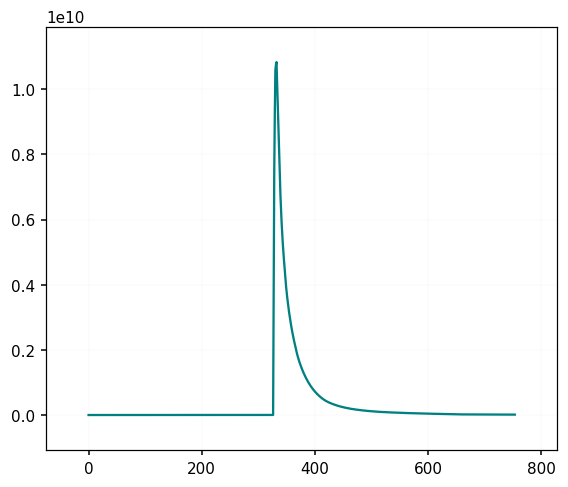

In [18]:
s = store_bxbt_belowx[1]
plt.plot(s["Rprofiles"][1])

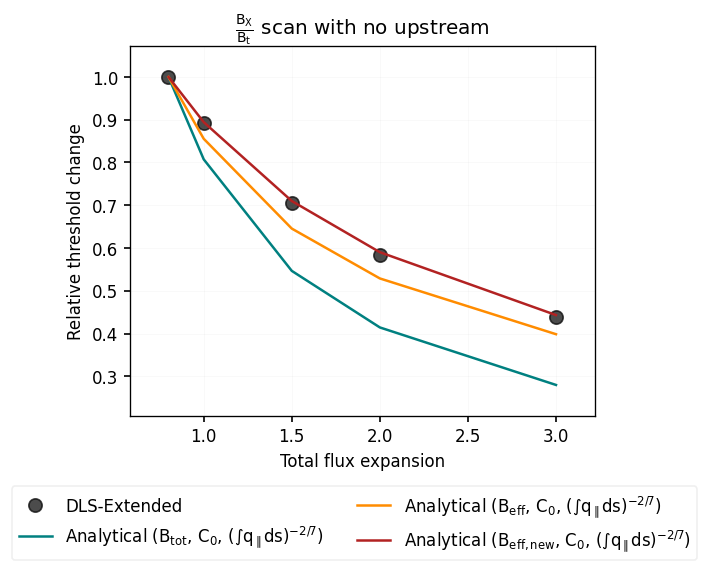

In [45]:
df = get_detachment_scalings(profiles_bxbt_belowx, store_bxbt_belowx)
x = df["BxBt"]


threshcalc = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
threshcalc2 = (df["BxBt_eff_old"]/df["BxBt_eff_old"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
threshcalc3 = (df["BxBt_eff_old"]/df["BxBt_eff_old"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7) * (df["C0"]/df["C0"][0])**(-1)
threshcalc4 = (df["BxBt_eff_old"]/df["BxBt_eff_old"][0])**(-1) * (df["qpar_integral"]/df["qpar_integral"][0])**(-2/7) * (df["C0"]/df["C0"][0])**(-1)
threshcalc5 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["qpar_integral"]/df["qpar_integral"][0])**(-2/7) * (df["C0"]/df["C0"][0])**(-1)
threshcalc6 = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["qpar_integral"]/df["qpar_integral"][0])**(-2/7) * (df["C0"]/df["C0"][0])**(-1)
# threshcalc5 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["Tu"]/df["Tu"][0])**(-1) * (df["C0"]/df["C0"][0])**(-1)


fig, axes = plt.subplots(dpi = 120, figsize = (5,4))
ms = 0
axes.set_title(r"$\frac{B_{X}}{B_{t}}$ scan with no upstream")
axes.plot(x, df["thresholds"]/df["thresholds"][0], marker = "o", lw = 0, ms = 8, c = "k", alpha = 0.7, label = "DLS-Extended")
# axes.plot(x, threshcalc, marker = "x", label = "Analytical", ms = ms, lw = 1.5)
# axes.plot(x, threshcalc2, marker = "*", label = "Analytical ($B_{eff}$)", ms = ms, lw = 1.5)
# axes.plot(x, threshcalc3, marker = "v", label = "Analytical ($B_{eff}$, $C_{0}$)", ms = ms, lw = 1.5)
axes.plot(x, threshcalc6, marker = "d", label = "Analytical ($B_{tot}$, $C_{0}$, $(\int q_{\parallel} ds)^{-2/7}$)", ms = ms, lw = 1.5)
axes.plot(x, threshcalc4, marker = "d", label = "Analytical ($B_{eff}$, $C_{0}$, $(\int q_{\parallel} ds)^{-2/7}$)", ms = ms, lw = 1.5)
axes.plot(x, threshcalc5, marker = "d", label = "Analytical ($B_{eff, new}$, $C_{0}$, $(\int q_{\parallel} ds)^{-2/7}$)", ms = ms, lw = 1.5)
# axes.plot(x, threshcalc5, marker = "d", label = "Analytical ($B_{eff}$, $C_{0}$, $T_{u}^{-1}$)", ms = ms, lw = 1.5)
axes.set_xlabel("Total flux expansion")
axes.set_ylabel("Relative threshold change")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.02), ncols = 2)



## Lc

In [118]:
store_Lc.keys()

dict_keys([0.8, 1, 1.5, 2, 3])

0    1.529598
1    1.510232
2    1.474604
3    1.454302
4    1.432890
Name: BxBt_eff, dtype: float64


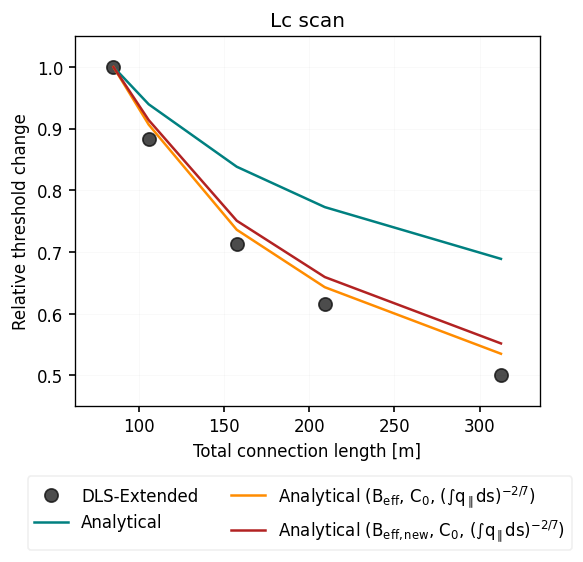

In [51]:
df = get_detachment_scalings(profiles_Lc, store_Lc)
x = df["L"]


threshcalc = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
threshcalc2 = (df["BxBt_eff_old"]/df["BxBt_eff_old"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
threshcalc3 = (df["BxBt_eff_old"]/df["BxBt_eff_old"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7) * (df["C0"]/df["C0"][0])**(-1)
threshcalc4 = (df["BxBt_eff_old"]/df["BxBt_eff_old"][0])**(-1) * (df["qpar_integral"]/df["qpar_integral"][0])**(-2/7) * (df["C0"]/df["C0"][0])**(-1)
threshcalc5 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["qpar_integral"]/df["qpar_integral"][0])**(-2/7) * (df["C0"]/df["C0"][0])**(-1)
# threshcalc5 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["Tu"]/df["Tu"][0])**(-1) * (df["C0"]/df["C0"][0])**(-1)


fig, axes = plt.subplots(dpi = 120, figsize = (5,4))
ms = 0
axes.set_title(r"Lc scan")
axes.plot(x, df["thresholds"]/df["thresholds"][0], marker = "o", lw = 0, ms = 8, c = "k", alpha = 0.7, label = "DLS-Extended")
axes.plot(x, threshcalc, marker = "x", label = "Analytical", ms = ms, lw = 1.5)
# axes.plot(x, threshcalc2, marker = "*", label = "Analytical ($B_{eff}$)", ms = ms, lw = 1.5)
# axes.plot(x, threshcalc3, marker = "v", label = "Analytical ($B_{eff}$, $C_{0}$)", ms = ms, lw = 1.5)
axes.plot(x, threshcalc4, marker = "d", label = "Analytical ($B_{eff}$, $C_{0}$, $(\int q_{\parallel} ds)^{-2/7}$)", ms = ms, lw = 1.5)
axes.plot(x, threshcalc5, marker = "d", label = "Analytical ($B_{eff, new}$, $C_{0}$, $(\int q_{\parallel} ds)^{-2/7}$)", ms = ms, lw = 1.5)
# axes.plot(x, threshcalc5, marker = "d", label = "Analytical ($B_{eff}$, $C_{0}$, $T_{u}^{-1}$)", ms = ms, lw = 1.5)
axes.set_xlabel("Total connection length [m]")
axes.set_ylabel("Relative threshold change")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.02), ncols = 2)

# axes[1].plot(BxBt, BxBt_eff)

print(df["BxBt_eff"])


In [182]:
s["state"].T.shape

(1004,)

# Check radiation calc

In [35]:
s["constants"]["Lfunc"]

Text(0, 0.5, 'T')

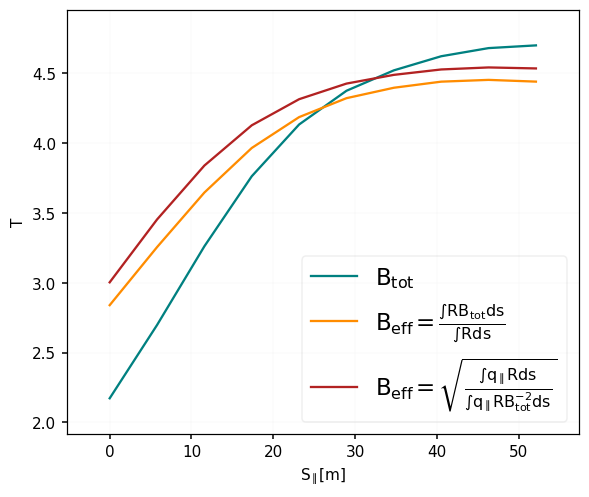

In [31]:
p = profiles_Lc[1]
s = store_Lc[1]
i = 1

    
Nu = s["state"].nu
cz0 = s["state"].cz
Lfunc = LfuncKallenbach("Ar")
Tu = s["Tprofiles"][i][-1]
T = s["Tprofiles"][i]
S = s["Sprofiles"][i]
Btot = s["Btotprofiles"][i]
Xpoint = s["Xpoints"][i]
q = s["Qprofiles"][i]

Pu = Tu * Nu
N = Pu / T

Lz = np.array([Lfunc(x) for x in T])

R = N * N*cz0 * Lz   # Wm-3

qradial = np.ones_like(S)
qradial[Xpoint:] = s["state"].qradial


## Radiated power in W (excludes B effects)
Prad = np.gradient(q/Btot, S) + qradial/Btot

df = pd.DataFrame()

for i,_ in enumerate(s["Splot"]):
    
    Tu = s["Tprofiles"][i][-1]
    T = s["Tprofiles"][i]
    S = s["Sprofiles"][i]
    Btot = s["Btotprofiles"][i]
    Xpoint = s["Xpoints"][i]
    q = s["Qprofiles"][i]

    Pu = Tu * nu0
    N = Pu / T

    Lz = np.array([Lfunc(x) for x in T])

    R = N * N*cz0 * Lz   # Wm-3
    
    R = np.nan_to_num(R, nan=0)
    
    fid = np.argmin(np.abs(S - s["Splot"][i]))
    df.loc[i, "Btot"] = Btot[fid]
    df.loc[i, "Beff1"] = sp.integrate.trapezoid(y = R*Btot, x = S) / sp.integrate.trapezoid(y = R, x = S)
    df.loc[i, "Beff2"] = np.sqrt(sp.integrate.trapezoid(y = q*R, x = S) / sp.integrate.trapezoid(y = q*R/Btot**2, x = S))

fig, ax = plt.subplots()
# ax.plot(S, R, label = "R [W/m^3]")
# ax.plot(S, Prad)
# ax.plot(S, Prad2)

# ax.plot(S, Btot, label = "Btot")
ax.plot(s["Splot"], df["Btot"], label = "$B_{tot}$")
ax.plot(s["Splot"], df["Beff1"], label = r"$B_{eff} = \frac{\int{ R B_{tot}} ds} {\int{R} ds}$")
ax.plot(s["Splot"], df["Beff2"], label = r"$B_{eff} = \sqrt{\frac{\int{ q_{\parallel} R} ds} {\int{q_{\parallel}R B_{tot}^{-2}} ds}}$")

# ax.set_yscale("log")
ax.legend(fontsize = 15)
# plt.plot(s["Sprofiles"][1], s["Rprofiles"][1])

# ax.set_xlim(0, 0.02)
ax.set_xlabel(r"$S_{\parallel} [m]$")
ax.set_ylabel("T")



In [237]:
sp.integrate.trapezoid(y = R*Btot, x = S) / sp.integrate.trapezoid(y = R, x = S)

nan

In [239]:
R.shape

(2000,)

## Lc, thin curve

In [68]:
def get_Lx(profile):
    return profile["S"][profile["Xpoint"]]

def get_upstream_integral_linear(profile):
    """
    Calculates the detachment scaling for the upstream assuming linearly increasing qpar
    
    """
    S = profile["S"]
    Lpar = S[-1]
    Xpoint = profile["Xpoint"]
    Sx = S[Xpoint]
    B = profile["Btot"]
    Bx = B[Xpoint]
    
    abovex = sp.integrate.trapezoid(y = B[Xpoint:]/Bx * (Lpar - S[Xpoint:])/(Lpar - Sx), x = S[Xpoint:])
    belowx = sp.integrate.trapezoid(y = B[:Xpoint]/Bx, x = S[:Xpoint])
    
    return (abovex + belowx)
        
def get_upstream_integral(profile, store):
    """
    Calculates the detachment scaling for the upstream taking actual qpar
    """
    S = profile["S"]
    Lpar = S[-1]
    Xpoint = profile["Xpoint"]
    Sx = S[Xpoint]
    B = profile["Btot"]
    Bx = B[Xpoint]
    qpar = store["Qprofiles"][0]
    qx = qpar[Xpoint]
    
    integral = sp.integrate.trapezoid(y = qpar, x = S)
    
    return integral


[1.         1.0003548  1.00062202 1.00070995 1.00077698]


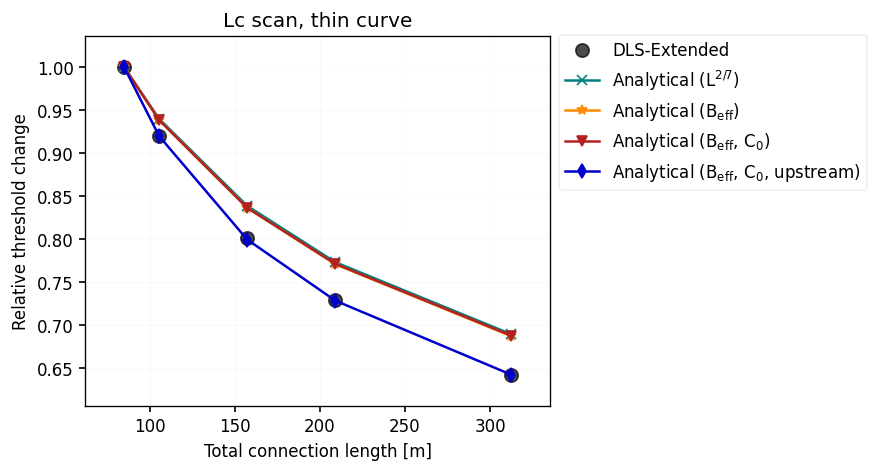

In [96]:
df = get_detachment_scalings(profiles_Lc, store_Lc_thin, lambda x: LfuncArParametricTri(x, 60))

threshcalc = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(-2/7)
threshcalc2 = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["L"]/df["L"][0])**(-4/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
threshcalc3 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
threshcalc4 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7) * (df["C0"]/df["C0"][0])**(-1)
threshcalc5 = (df["BxBt_eff"]/df["BxBt_eff"][0])**(-1) * (df["upstream_integrals_linear"]/df["upstream_integrals_linear"][0])**(-2/7) * (df["C0"]/df["C0"][0])**(-1)
print(avgB_ratio_eff/avgB_ratio_eff[0])

fig, axes = plt.subplots(dpi = 120, figsize = (5,4))

axes.set_title(r"Lc scan, thin curve")
axes.plot(L, df["thresholds"]/df["thresholds"][0], marker = "o", lw = 0, ms = 8, c = "k", alpha = 0.7, label = "DLS-Extended")
# axes.plot(L, DLS_thresholds/DLS_thresholds[0], marker = "d", lw = 0, ms = 5, c = "yellow", alpha = 0.7, label = "DLS-Classic")
axes.plot(L, threshcalc, marker = "x", label = "Analytical ($L^{2/7}$)", ms = 6, lw = 1.5)
axes.plot(L, threshcalc3, marker = "*", label = "Analytical ($B_{eff}$)", ms = 6, lw = 1.5)
axes.plot(L, threshcalc4, marker = "v", label = "Analytical ($B_{eff}$, $C_{0}$)", ms = 6, lw = 1.5)
axes.plot(L, threshcalc5, marker = "d", label = "Analytical ($B_{eff}$, $C_{0}$, upstream)", ms = 6, lw = 1.5)
axes.set_xlabel("Total connection length [m]")
axes.set_ylabel("Relative threshold change")
fig.legend(loc = "upper left", bbox_to_anchor = (0.9,0.9))

# axes[1].plot(BxBt, BxBt_eff)


# Capture impact of upstream region

52.09780554760034 42.75729561883935


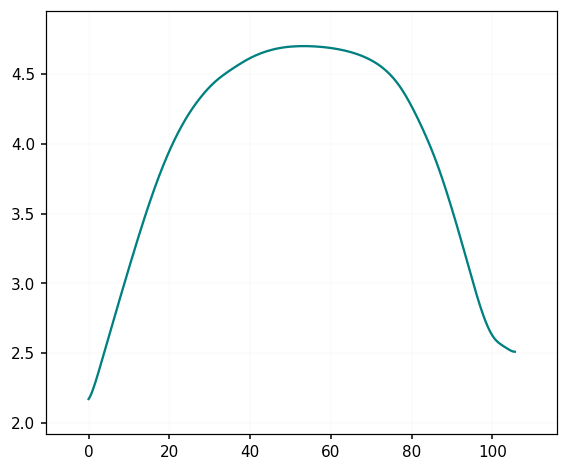

In [37]:
profiles = profiles_Lc
stores = store_Lc_thin
case = 1
profile = profiles[case]
store = stores[case]

B = profile["Btot"]
Xpoint = profile["Xpoint"]
S = profile["S"]

int_downstream = sp.integrate.trapezoid(y = B[:Xpoint]/B[Xpoint], x = S[:Xpoint])

print(S[Xpoint], int_downstream)

fig, ax = plt.subplots()
ax.plot(S,B)

# Run original DLS

In [25]:
from ThermalFrontFormulation import *

profiles = profiles_Lc
stores = store_Lc_thin
case = 1
profile = profiles[case]
store = stores[case]

thresholds = []
def get_dls_threshold(profile, store):
    
    return CfInt(
        spar = profile["S"], 
        B_field = profile["Btot"], 
        sx = profile["S"][profile["Xpoint"]], 
        L = profile["S"][-1],
        sh = store["Splot"][0]
    )
    

for case in profiles:
    thresholds.append(get_dls_threshold(profiles[case], stores[case]))
    
thresholds

[3903757179157.1426,
 3591551261147.2617,
 3122189804269.9424,
 2843302770953.993,
 2504730803556.047]

## Lc scan, thin curve, qpllt = 10kW/m2

In [26]:
store = store_Lc_thin_loqt
profiles = profiles_Lc

thresholds = np.array([store[x]["threshold"] for x in profiles])
windows = np.array([store[x]["window_ratio"] for x in profiles]) 
L = np.array([profiles[x].get_connection_length() for x in profiles])
BxBt = np.array([profiles[x].get_total_flux_expansion() for x in profiles])
frac_gradB = np.array([profiles[x].get_average_frac_gradB() for x in profiles])
avgB_ratio = np.array([profiles[x].get_average_B_ratio() for x in profiles])
front_dfs = [get_front_widths(profiles[x], store[x], Rcutoff = 0.9) for x in profiles]
BxBt_eff = [df["Btot_eff"].iloc[-1] / df["Btot_eff"].iloc[0] for df in front_dfs]
Lfunc = lambda x: LfuncArParametricTri(x, 60)
C0 = [get_c0(store[x], Lfunc) for x in profiles]
DLS_thresholds = np.array([get_dls_threshold(profiles[x], store[x]) for x in profiles])

avgB_ratio_eff = []
for df in front_dfs:
    newS = np.linspace(df["Spar"].iloc[0], df["Spar"].iloc[-1], 100)
    Btot_eff_interp = sp.interpolate.make_interp_spline(df["Spar"], df["Btot_eff"])(newS)
    avgB_ratio_eff.append(df["Btot"].iloc[-1] / np.mean(Btot_eff_interp))

L_base = L[0]
BxBt_base = BxBt[0]
threshold_base = thresholds[0]
window_base = windows[0]
avgB_ratio_base = avgB_ratio[0]

threshcalc = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-2/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
threshcalc2 = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-4/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
threshcalc3 = (BxBt_eff/BxBt_eff[0])**(-1) * (L/L_base)**(-2/7) * (avgB_ratio_eff/avgB_ratio_eff[0])**(2/7)
threshcalc4 = (BxBt_eff/BxBt_eff[0])**(-1) * (L/L_base)**(-2/7) * (avgB_ratio_eff/avgB_ratio_eff[0])**(2/7) * (C0/C0[0])**(-1)
print(avgB_ratio_eff/avgB_ratio_eff[0])

fig, axes = plt.subplots(dpi = 120, figsize = (5,4))

axes.set_title(r"Lc scan, thin curve, low qpllt")
axes.plot(L, thresholds/threshold_base, marker = "o", lw = 0, ms = 8, c = "k", alpha = 0.7, label = "DLS-Extended")
axes.plot(L, DLS_thresholds/DLS_thresholds[0], marker = "o", lw = 0, ms = 8, c = "k", alpha = 0.7, label = "DLS-Classic")
axes.plot(L, threshcalc, marker = "x", label = "Analytical ($L^{2/7}$)", ms = 6, lw = 1.5)
axes.plot(L, threshcalc3, marker = "*", label = "Analytical ($B_{eff}$)", ms = 6, lw = 1.5)
axes.plot(L, threshcalc4, marker = "v", label = "Analytical ($B_{eff}$, $C_{0}$)", ms = 6, lw = 1.5)
axes.set_xlabel("Total connection length [m]")
axes.set_ylabel("Relative threshold change")
fig.legend(loc = "upper left", bbox_to_anchor = (0.9,0.9))

# axes[1].plot(BxBt, BxBt_eff)


NameError: name 'store_Lc_thin_loqt' is not defined

In [185]:
s.keys()

dict_keys([0.8])

In [186]:
s = store_Lc
s[0.8]["Rprofiles"][0]

array([3.00039493e+05, 2.26202259e+08, 4.15325834e+08, ...,
       1.36774866e+06, 1.36784866e+06, 1.36790127e+06])

# Profile plots

## Lc

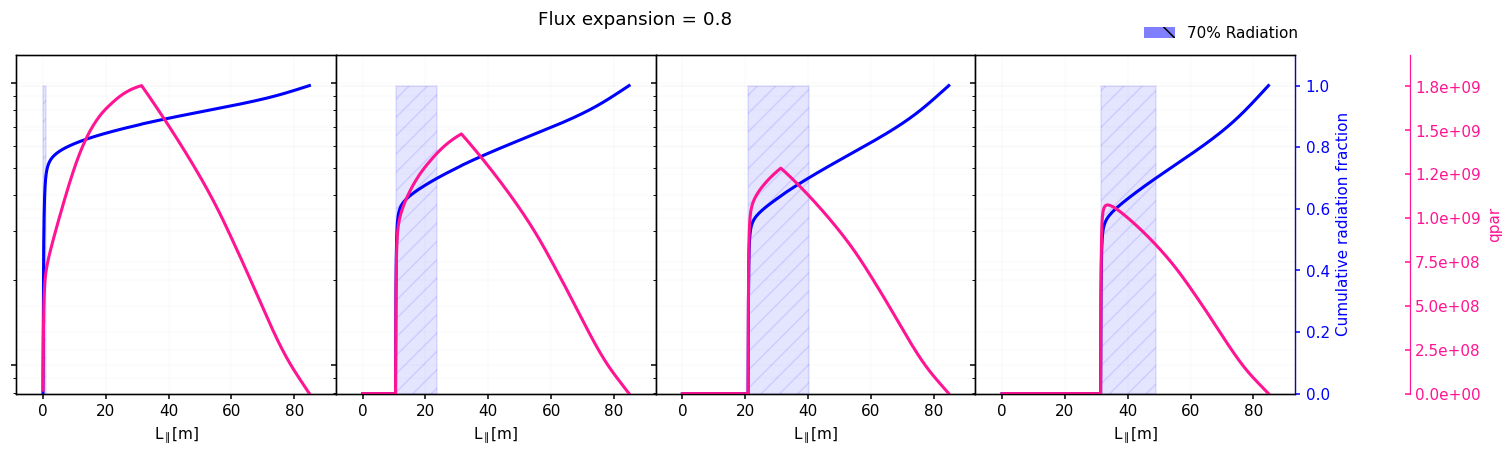

In [187]:
stores = store_Lc
profiles = profiles_Lc
for key in stores:
    p = profiles[key]
    s = stores[key]
    plot_profile_histories(p, s, [0,3,6,9], rad_threshold = 0.7, mode = "qpar", title = f"Flux expansion = {key}")

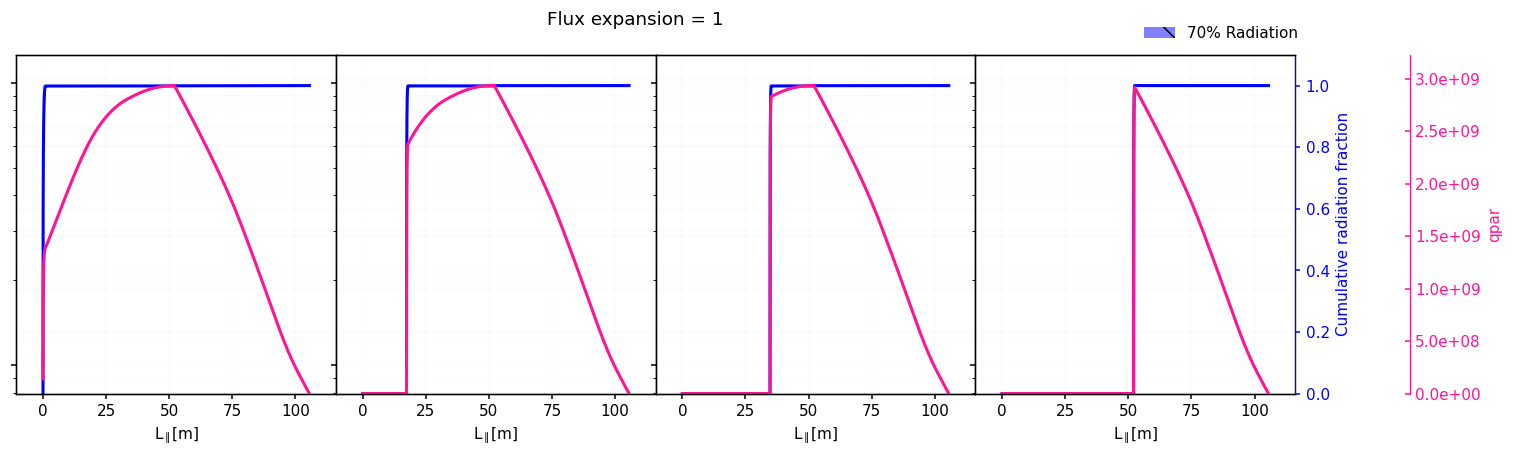

In [118]:
for BxBt in [1]:
    p = eqb["SPR45"]["ol"]
    s = store_Lc_thin[BxBt]
    plot_profile_histories(p, s, [0,3,6,9], rad_threshold = 0.7, mode = "qpar", title = f"Flux expansion = {BxBt}")

In [132]:
q.shape

(1235,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


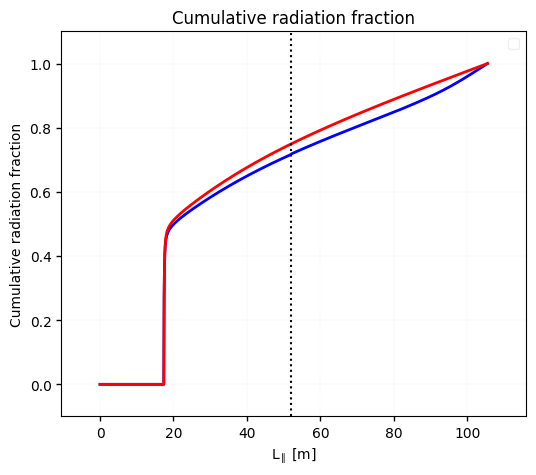

In [143]:
plt.close("all")


p = eqb["SPR45"]["ol"]
s = store_bxbt[1]
idx = 3


fig, ax = plt.subplots(dpi = 100)



S = s["Sprofiles"][idx]
Spol = s["Spolprofiles"][idx]
R = s["Rprofiles"][idx]  # W/m2
q = pad_profile(S, s["Qprofiles"][idx])  # W/m2
Btot = np.array(s["Btotprofiles"][idx])  # T
Bpol = np.array(s["Bpolprofiles"][idx])  # T

# Xpoint = np.argmin(np.abs(S - p["S"][p["Xpoint"]]))
Xpoint = s["Xpoints"][idx]
qradial = np.ones_like(S)
qradial[Xpoint:] = s["state"].qradial


x = S

Prad = np.gradient(q/Btot, x) + qradial/Btot
Pradcum = sp.integrate.cumulative_trapezoid(y = Prad, x = x, initial = 0)
Pradcum /= Pradcum.max()

R = pad_profile(x, R)
T = pad_profile(x, s["Tprofiles"][idx])

Rcum = sp.integrate.cumulative_trapezoid(y = R, x = x, initial = 0)
Rcum /= Rcum.max()

ax.plot(x, Pradcum, color = "blue", lw = 2,   alpha = 1)
ax.plot(x, Rcum, color = "red", lw = 2,   alpha = 1)

ax.axvline(x = p["S"][p["Xpoint"]], c = "k", ls = ":", lw = 1.5)

# ax.set_yscale("log")

ax.set_ylabel("Cumulative radiation fraction")
ax.set_title("Cumulative radiation fraction")

ax.set_xlabel(r"$L_{\parallel}$ [m]")
ax.legend()


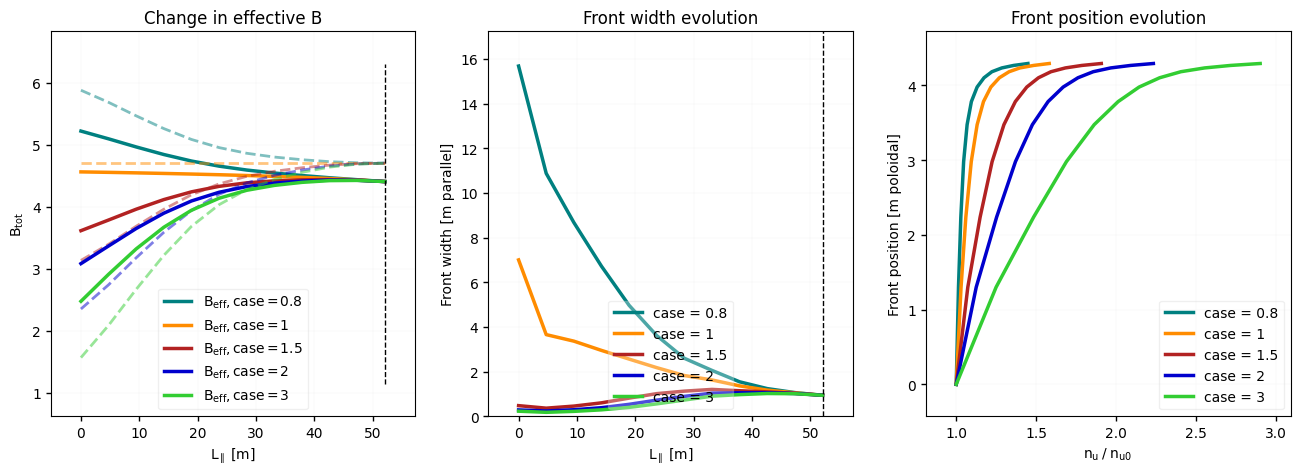

In [44]:
store = store_bxbt

fig, axes = plt.subplots(1,3, figsize = (16, 5), dpi = 100)
# fig.suptitle(store_name)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, casename in enumerate(store.keys()):
    s = store[casename]
    df = get_front_widths(p = eqb["SPR45"]["ol"], s = s, use_prad = True, Rcutoff = 0.5)
    axes[0].plot(df["Spar"], df["Btot_eff"], label = f"$B_{{eff}}, case = {casename}$", lw = 2.5, color = colors[i])
    axes[0].plot(df["Spar"], df["Btot"],  ms = 0, marker = "o", lw = 2, ls = "--", alpha = 0.5, color = colors[i])
    
    axes[1].plot(df["Spar"], df["Spar_front_width"], label = f"case = {casename}", lw = 2.5)
    axes[2].plot(df["crel"], df["Spol"], label = f"case = {casename}", lw = 2.5)
    


axes[0].vlines(newp["S"][newp["Xpoint"]], axes[0].get_ylim()[0], axes[0].get_ylim()[1], color = "k", lw = 1.0, linestyle = "--")
axes[0].legend(loc = "lower center")
axes[0].set_xlabel("$L_{\parallel}$ [m]")
axes[0].set_ylabel("$B_{tot}$")
axes[0].set_title("Change in effective B")


axes[1].set_ylim(0,None)
axes[1].vlines(newp["S"][newp["Xpoint"]], axes[1].get_ylim()[0], axes[1].get_ylim()[1], color = "k", lw = 1.0, linestyle = "--")
axes[1].legend(loc = "lower center")
axes[1].set_xlabel("$L_{\parallel}$ [m]")
axes[1].set_ylabel("Front width [m parallel]")
axes[1].set_title("Front width evolution")


axes[2].set_xlabel("$n_{u} \ /\  n_{u0}$")
axes[2].set_ylabel("Front position [m poloidal]")
axes[2].set_title("Front position evolution")
axes[2].legend(loc = "best")


## Analyse Lc

[1.         1.06038099 1.04098892 0.97616565 0.90972053]


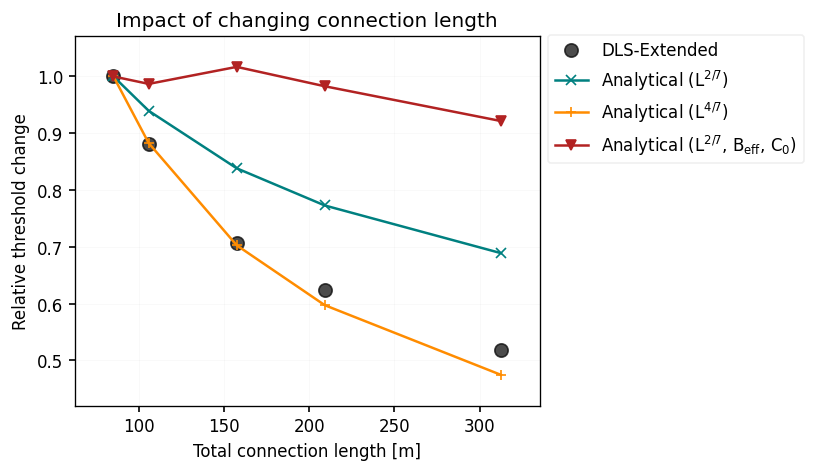

In [29]:
store = store_Lc
profiles = profiles_Lc

thresholds = np.array([store[x]["threshold"] for x in profiles])
windows = np.array([store[x]["window_ratio"] for x in profiles]) 
L = np.array([profiles[x].get_connection_length() for x in profiles])
BxBt = np.array([profiles[x].get_total_flux_expansion() for x in profiles])
frac_gradB = np.array([profiles[x].get_average_frac_gradB() for x in profiles])
avgB_ratio = np.array([profiles[x].get_average_B_ratio() for x in profiles])
front_dfs = [get_front_widths(profiles[x], store[x], Rcutoff = 0.9) for x in profiles]
BxBt_eff = [df["Btot_eff"].iloc[-1] / df["Btot_eff"].iloc[0] for df in front_dfs]
C0 = [get_c0(store[x]) for x in profiles]

avgB_ratio_eff = []
for df in front_dfs:
    newS = np.linspace(df["Spar"].iloc[0], df["Spar"].iloc[-1], 100)
    Btot_eff_interp = sp.interpolate.make_interp_spline(df["Spar"], df["Btot_eff"])(newS)
    avgB_ratio_eff.append(df["Btot"].iloc[-1] / np.mean(Btot_eff_interp))

L_base = L[0]
BxBt_base = BxBt[0]
threshold_base = thresholds[0]
window_base = windows[0]
avgB_ratio_base = avgB_ratio[0]

threshcalc = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-2/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
threshcalc2 = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-4/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
threshcalc3 = (BxBt_eff/BxBt_eff[0])**(-1) * (L/L_base)**(-4/7) * (avgB_ratio_eff/avgB_ratio_eff[0])**(2/7)
threshcalc4 = (BxBt_eff/BxBt_eff[0])**(-1) * (L/L_base)**(-2/7) * (avgB_ratio_eff/avgB_ratio_eff[0])**(2/7) * C0/C0[0]
print(avgB_ratio_eff/avgB_ratio_eff[0])

fig, axes = plt.subplots(dpi = 120, figsize = (5,4))

axes.set_title(r"Impact of changing connection length")
axes.plot(L, thresholds/threshold_base, marker = "o", lw = 0, ms = 8, c = "k", alpha = 0.7, label = "DLS-Extended")
axes.plot(L, threshcalc, marker = "x", label = "Analytical ($L^{2/7}$)", ms = 6, lw = 1.5)
axes.plot(L, threshcalc2, marker = "+", label = "Analytical ($L^{4/7}$)", ms = 6, lw = 1.5)
# axes.plot(L, threshcalc3, marker = "*", label = "Analytical ($L^{4/7}$ and $B_{eff}$)", ms = 6, lw = 1.5)
axes.plot(L, threshcalc4, marker = "v", label = "Analytical ($L^{2/7}$, $B_{eff}$, $C_{0}$)", ms = 6, lw = 1.5)
axes.set_xlabel("Total connection length [m]")
axes.set_ylabel("Relative threshold change")
fig.legend(loc = "upper left", bbox_to_anchor = (0.9,0.9))

# axes[1].plot(BxBt, BxBt_eff)


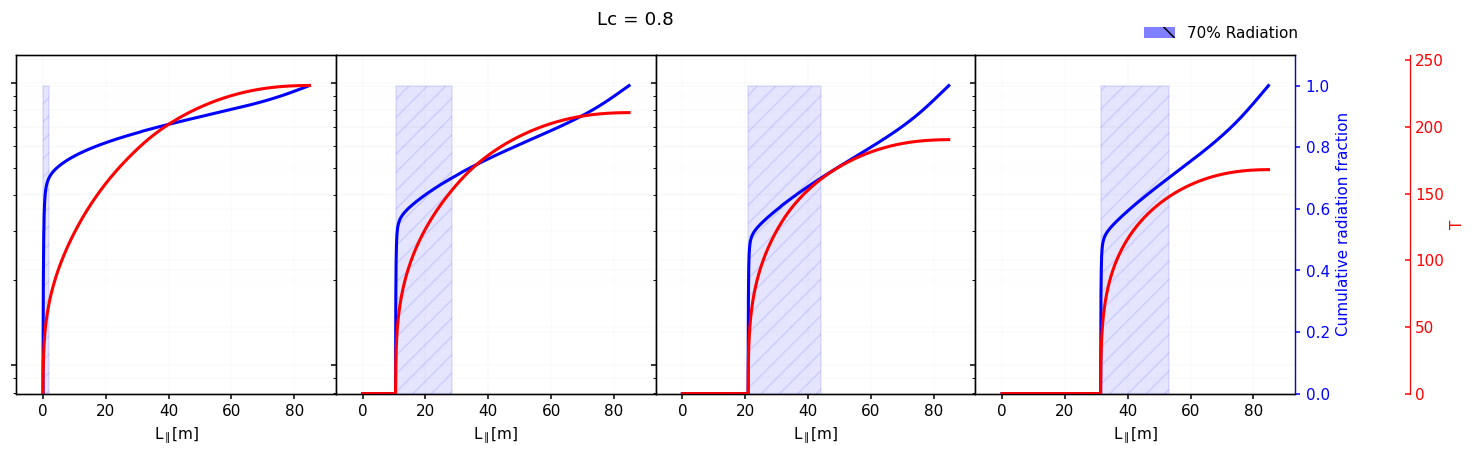

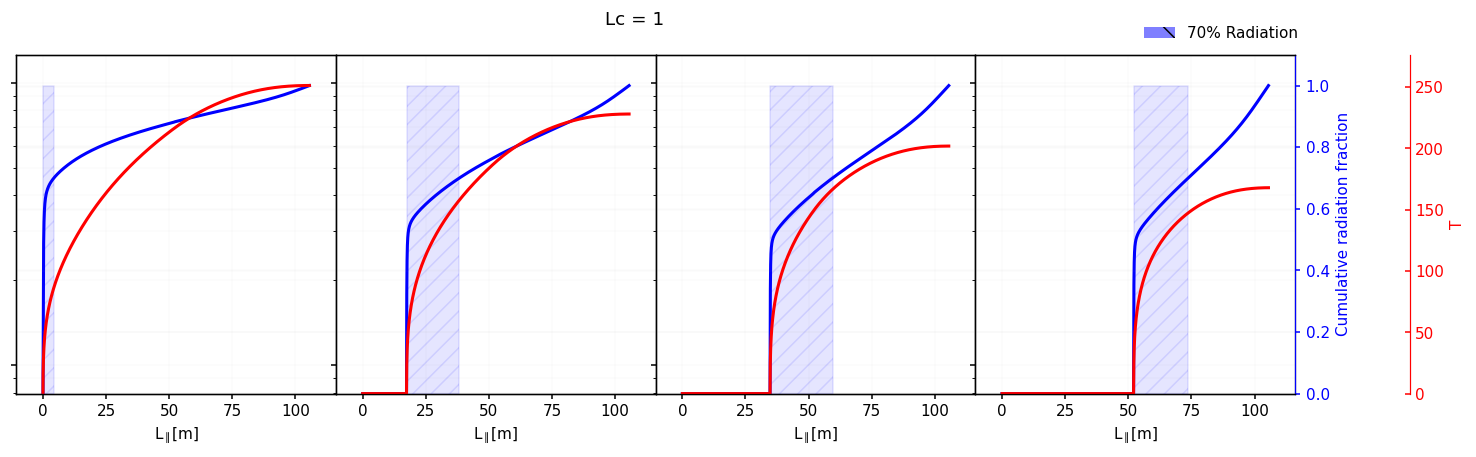

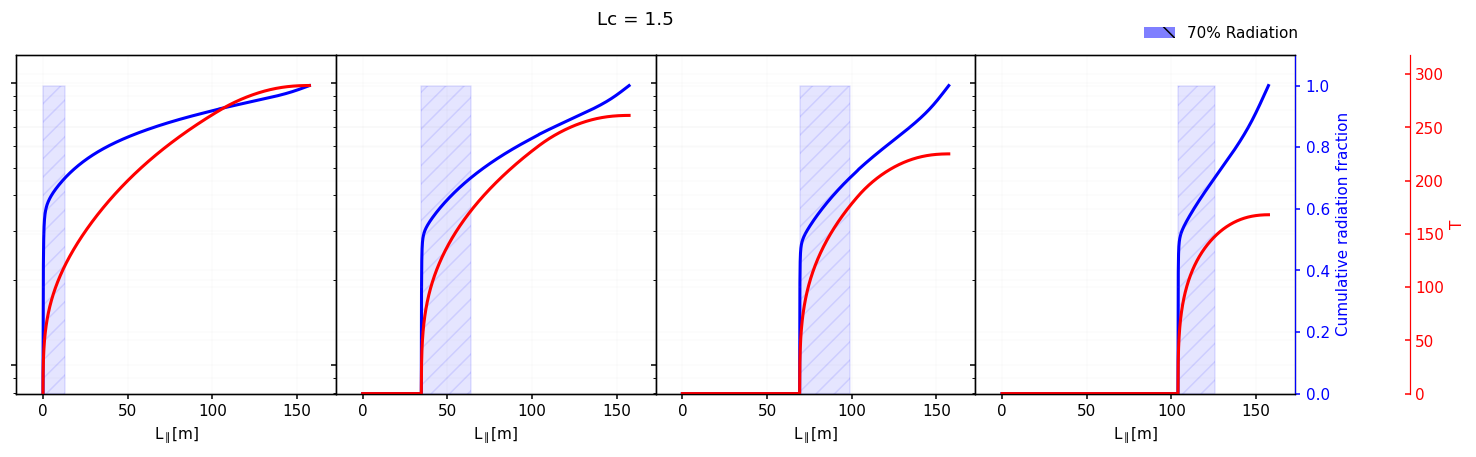

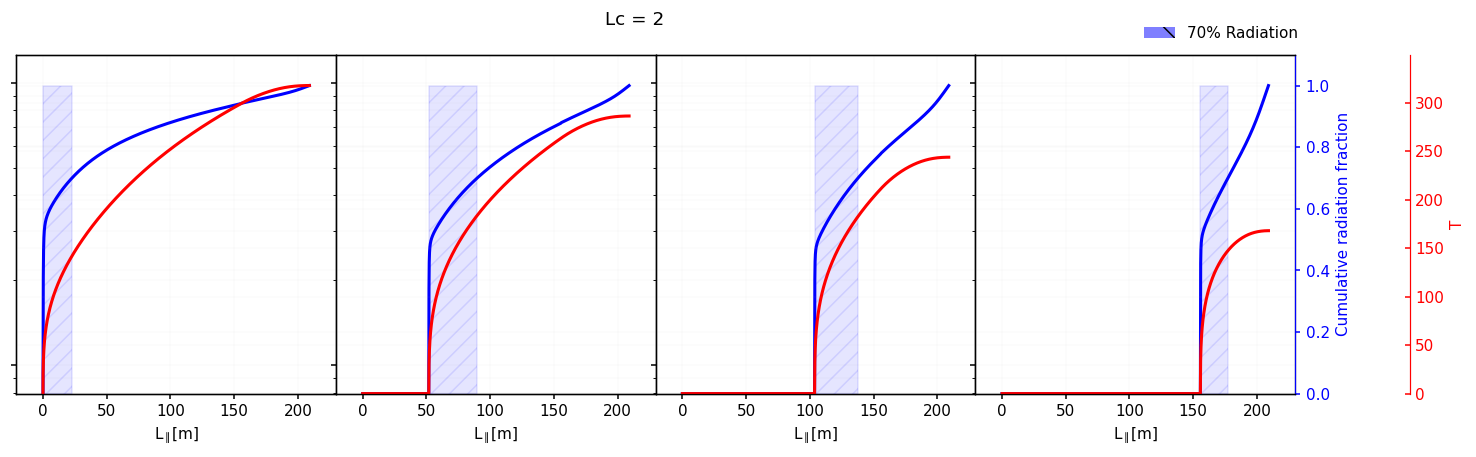

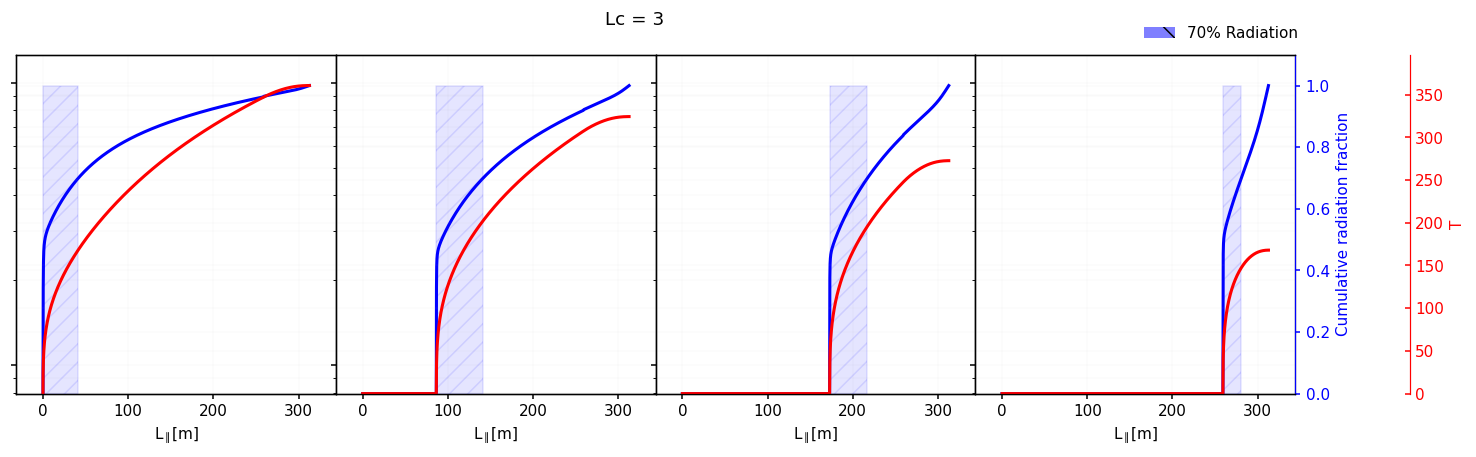

In [78]:
for key in store_Lc.keys():
    p = eqb["SPR45"]["ol"]
    s = store_Lc[key]
    plot_profile_histories(p, s, [0,3,6,9], rad_threshold = 0.7, mode = "temp", title = f"Lc = {key}")

In [67]:
for i, casename in enumerate(store.keys()):
    s = store[casename]
    print(s["cvar"][0], s["window_ratio"])

8.0508286237331e+19 2.1057624822359093
7.082917063390111e+19 2.34242202892544
5.677178969939977e+19 1.7813627006962212
4.8701201402216055e+19 1.5601219626118967
3.934765146159122e+19 1.3478019054976065


In [65]:
s.keys()

dict_keys(['Splot', 'SpolPlot', 'cvar', 'Sprofiles', 'Tprofiles', 'Rprofiles', 'Qprofiles', 'Spolprofiles', 'Btotprofiles', 'Bpolprofiles', 'Xpoints', 'logs', 'spar_onset', 'spol_onset', 'splot', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_frac', 'window_ratio', 'constants', 'radios', 'state'])

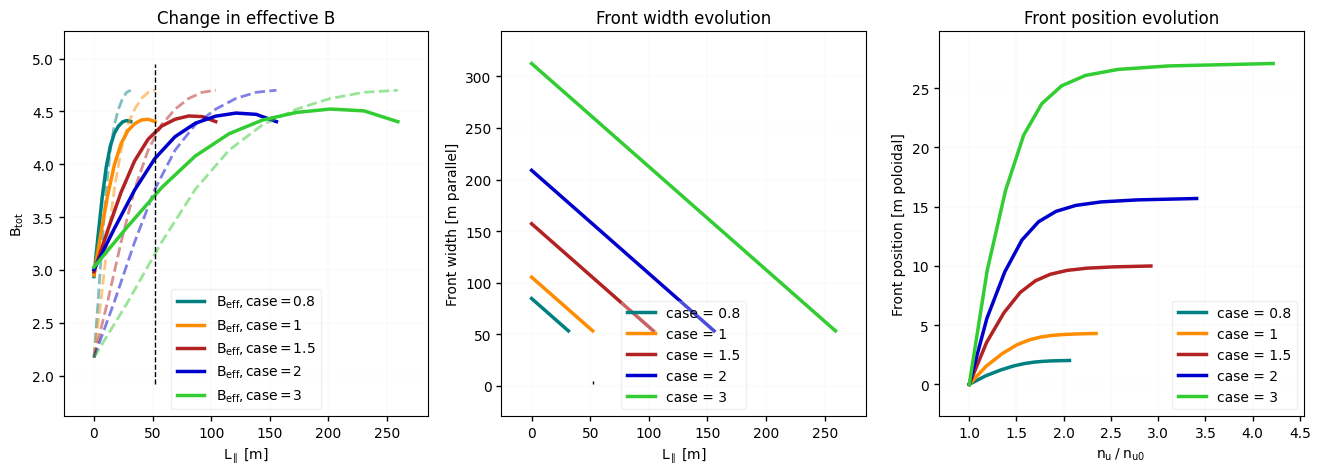

In [77]:
store = store_Lc

fig, axes = plt.subplots(1,3, figsize = (16, 5), dpi = 100)
# fig.suptitle(store_name)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, casename in enumerate(store.keys()):
    s = store[casename]
    df = get_front_widths(p = eqb["SPR45"]["ol"], s = s, Rcutoff = 1, use_prad = True)
    axes[0].plot(df["Spar"], df["Btot_eff"], label = f"$B_{{eff}}, case = {casename}$", lw = 2.5, color = colors[i])
    axes[0].plot(df["Spar"], df["Btot"],  ms = 0, marker = "o", lw = 2, ls = "--", alpha = 0.5, color = colors[i])
    
    axes[1].plot(df["Spar"], df["Spar_front_width"], label = f"case = {casename}", lw = 2.5)
    axes[2].plot(df["crel"], df["Spol"], label = f"case = {casename}", lw = 2.5)
    



axes[0].vlines(newp["S"][newp["Xpoint"]], axes[0].get_ylim()[0], axes[0].get_ylim()[1], color = "k", lw = 1.0, linestyle = "--")
axes[0].legend(loc = "lower center")
axes[0].set_xlabel("$L_{\parallel}$ [m]")
axes[0].set_ylabel("$B_{tot}$")
axes[0].set_title("Change in effective B")

axes[1].vlines(newp["S"][newp["Xpoint"]], axes[0].get_ylim()[0], axes[0].get_ylim()[1], color = "k", lw = 1.0, linestyle = "--")
axes[1].legend(loc = "lower center")
axes[1].set_xlabel("$L_{\parallel}$ [m]")
axes[1].set_ylabel("Front width [m parallel]")
axes[1].set_title("Front width evolution")

axes[2].set_xlabel("$n_{u} \ /\  n_{u0}$")
axes[2].set_ylabel("Front position [m poloidal]")
axes[2].set_title("Front position evolution")
axes[2].legend(loc = "best")


## How to get average radiation averaged B below the X-point?

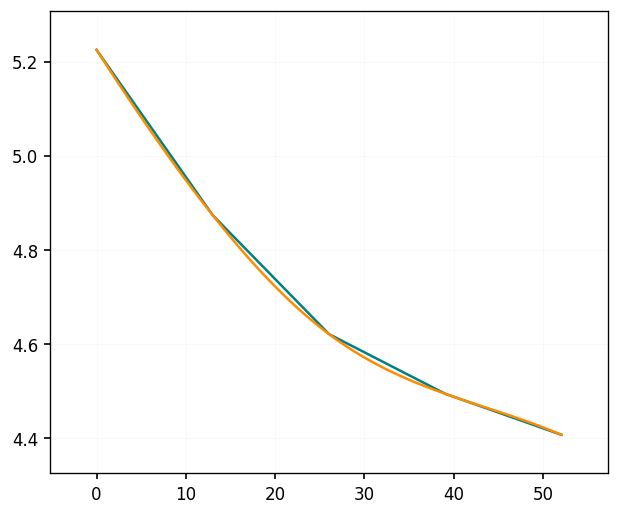

In [94]:
fig, ax = plt.subplots()

df = front_dfs[0]

newS = np.linspace(df["Spar"].iloc[0], df["Spar"].iloc[-1], 100)
Btot_eff_interp = sp.interpolate.make_interp_spline(df["Spar"], df["Btot_eff"])(newS)
ax.plot(df["Spar"], df["Btot_eff"])
ax.plot(newS, Btot_eff_interp)

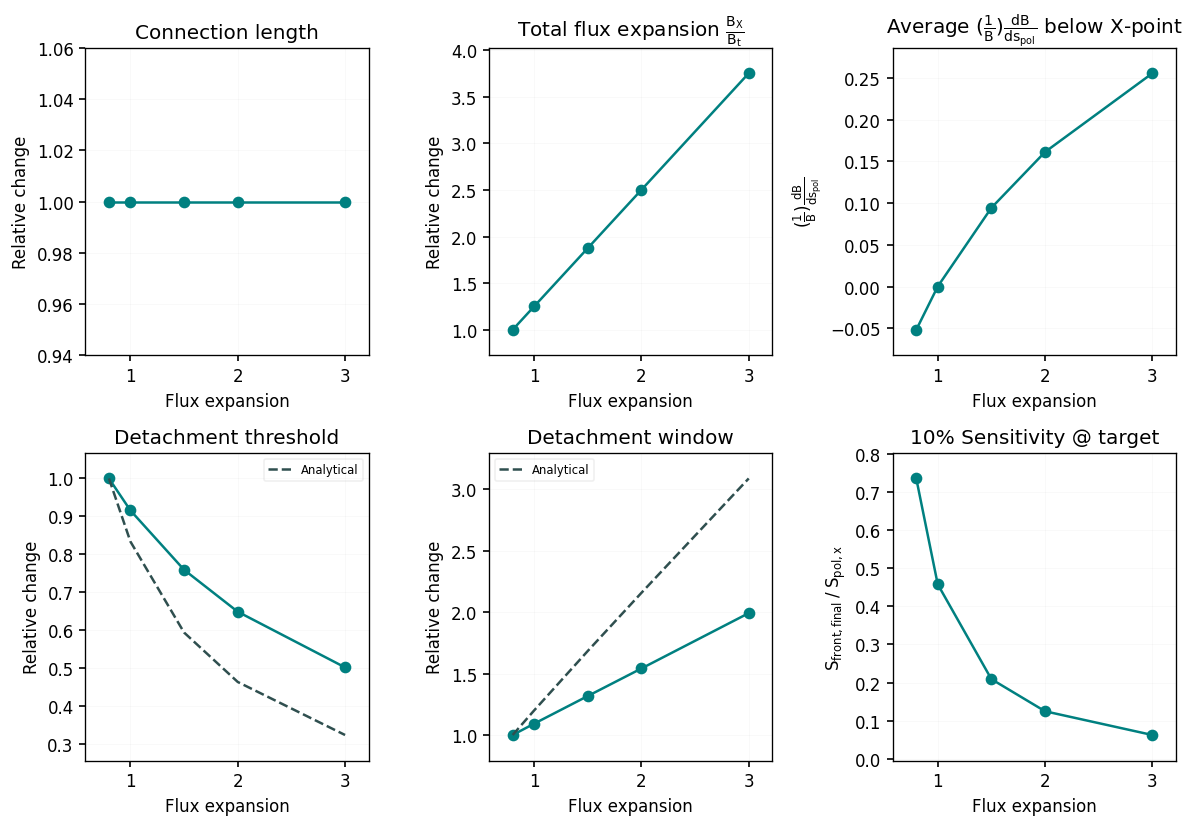

In [46]:
store = store_bxbt
sens = True
profiles = profiles_bxbt
show_47 = False
xlabel = "Flux expansion"

fig, axes = plt.subplots(2,3, dpi = 120, figsize = (10,7))

    
thresholds = np.array([store[x]["threshold"] for x in profiles])
windows = np.array([store[x]["window_ratio"] for x in profiles]) 
L = np.array([profiles[x].get_connection_length() for x in profiles])
BxBt = np.array([profiles[x].get_total_flux_expansion() for x in profiles])
frac_gradB = np.array([profiles[x].get_average_frac_gradB() for x in profiles])
avgB_ratio = np.array([profiles[x].get_average_B_ratio() for x in profiles])

if sens:
    target_sens = np.array([get_sensitivity(store[x]["crel_trim"], store[x]["SpolPlot"], fluctuation=1.05, location=0.0) for x in profiles])

L_base = L[0]
BxBt_base = BxBt[0]
threshold_base = thresholds[0]
window_base = windows[0]
avgB_ratio_base = avgB_ratio[0]
    
threshcalc = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-2/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
threshcalc2 = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-4/7) * (avgB_ratio/avgB_ratio_base)**(2/7)

windowcalc = (BxBt/BxBt_base)**(1) * (L/L_base)**(2/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
windowcalc2 = (BxBt/BxBt_base)**(1) * (L/L_base)**(4/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)

index = list(profiles.keys())
# index /= index[0]

# index = np.linspace(0,1,5)+i
axes[0,0].set_title("Connection length")
axes[0,0].plot(index, L/L_base, marker = "o")

axes[0,1].set_title(r"Total flux expansion $\frac{B_{X}}{B_{t}}$")
axes[0,1].plot(index, BxBt/BxBt_base, marker = "o")

axes[0,2].set_title(r"Average $(\frac{1}{B}) \frac{dB}{ds_{pol}}$ below X-point")
axes[0,2].plot(index, frac_gradB, marker = "o")

axes[1,0].set_title(r"Detachment threshold")
axes[1,0].plot(index, thresholds/threshold_base, marker = "o")

if show_47:
    label_27 = "Analytical, $L^{2/7}$"
else:
    label_27 = "Analytical"
    
axes[1,0].plot(index, threshcalc, color = "darkslategrey", ls = "--", label = label_27, zorder = 200)

if show_47:
    axes[1,0].plot(index, threshcalc2, color = "darkslategrey", ls = ":", label = "Analytical, $L^{4/7}$", zorder = 100)
axes[1,0].legend(fontsize = "x-small")

axes[1,1].set_title(r"Detachment window")
axes[1,1].plot(index, windows/window_base, marker = "o")
axes[1,1].plot(index, windowcalc, color = "darkslategrey", ls = "--", label = label_27, zorder = 100)

if show_47:
    axes[1,1].plot(index, windowcalc2, color = "darkslategrey", ls = ":", label = "Analytical, $L^{4/7}$", zorder = 100)
axes[1,1].legend(fontsize = "x-small")


axes[1,2].set_title(r"10% Sensitivity @ target")

if sens: 
    axes[1,2].plot(index, target_sens, marker = "o")

for ax in axes.flatten():
    ax.set_xlabel(xlabel)

for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]:
    ax.set_ylabel("Relative change")
    
axes[0,2].set_ylabel(r"$(\frac{1}{B}) \frac{dB}{ds_{pol}}$")
axes[1,2].set_ylabel("$S_{front, final} \ /\  S_{pol, x}$")
fig.tight_layout()

In [43]:
index

[0.8, 1, 1.5, 2, 3]